## Descrição do problema (k-centros)
Dado um conjunto de $n$ pontos e um parâmetro $k$, deseja-se encontrar $k$ centros de forma que os pontos estejam o mais próximo possível desses centros (cada ponto está localizado a uma distância máxima $r$ de um dos centros).

**Entrada:** Conjunto de pontos $S = {s_1, s_2, ..., s_n}$; Função(métrica) de distância $\text{dist}: S \times S \rightarrow \mathbb{R}^+$; Inteiro (número de centros) $k$.

**Saída:** Conjunto de centros $C = {c_1, c_2, ..., c_k}$

**Objetivo:** minimizar o $r$ máximo dos clusters, $r(C) = \max \{ \text{dist}(s_i, C) \}$ onde $\text{dist}(s_i, C) = \min \{ \text{dist}(s_i, c_j) \}$


In [205]:
# bibliotecas

import numpy as np
from ucimlrepo import fetch_ucirepo
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
import csv
import time

In [206]:
# dataset (Wine)

wine = fetch_ucirepo(id=109)   
# absenteeism_at_work = fetch_ucirepo(id=445) 
# dry_bean = fetch_ucirepo(id=602) 
# rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
# raisin = fetch_ucirepo(id=850) 
# wine_quality = fetch_ucirepo(id=186) 
  

In [207]:
# dados (datasets tipo pandas)

# Wine
X = wine.data.features # features de cada vinho (178 x 13), tipo contínuo/int
y = wine.data.targets  # classes dos vinhos (178 x 1), existem 3 classes distintas

# Ausência no trabalho 740 instâncias 
# X = absenteeism_at_work.data.features 
# y = absenteeism_at_work.data.targets 
# print(y)

# Dry Bean 13611 instâncias
# X = dry_bean.data.features 
# y = dry_bean.data.targets
# print(y) 

# Rice 3810 instâncias
# X = rice_cammeo_and_osmancik.data.features 
# y = rice_cammeo_and_osmancik.data.targets 

# Raisins 900 instâncias
# X = raisin.data.features 
# y = raisin.data.targets 

# Wine quality
# X = wine_quality.data.features 
# y = wine_quality.data.targets 

samples = X.shape[0] 

### ***Métricas:*** Distância de Minkowski
A distância entre dois pontos $x$ e $y$ em $\mathbb{R}^n$ é dada por:

$$
\text{dist}(x, y) = \left( \sum_{i=1}^{n} |x_i - y_i|^p \right)^{\frac{1}{p}}
$$

In [208]:
def minkowski_dist(x,y,p):
    # x, y -> tuplas
    # p -> int
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    d = 0
    
    d = np.sum(np.power(np.abs(x - y), p))
    
    return np.power(d, 1 / p)

### Matrizes de distância entre os pontos 
$p=1$: Distância de Manhattan

In [209]:
def getDistMatrix(samp, X, p):
    matrix = np.zeros((samp, samp))
    for i in range(samp):
        for j in range(i + 1, samp):
            dist = minkowski_dist(X[i], X[j], p)
            matrix[i, j] = dist
            matrix[j, i] = dist  # simetria
    return matrix
            
X_arr = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X) # convertendo o dataset pra numpy (evitar erro de indexação)
manhattan_d = getDistMatrix(samples, X_arr, p=1)
print(manhattan_d)

[[  0.    51.06 152.48 ... 257.14 249.41 558.28]
 [ 51.06   0.   148.3  ... 257.98 250.55 521.18]
 [152.48 148.3    0.   ... 384.76 376.83 649.14]
 ...
 [257.14 257.98 384.76 ...   0.     8.15 306.74]
 [249.41 250.55 376.83 ...   8.15   0.   312.09]
 [558.28 521.18 649.14 ... 306.74 312.09   0.  ]]


$p=2$: Distância Euclidiana

In [210]:
euclid_d = getDistMatrix(samples, X_arr, p=2)
print(euclid_d)

[[  0.          31.26501239 122.83115403 ... 230.24002302 225.21518399
  506.05936766]
 [ 31.26501239   0.         135.22469301 ... 216.22123207 211.21353863
  490.23526821]
 [122.83115403 135.22469301   0.         ... 350.57118792 345.56265177
  625.07017782]
 ...
 [230.24002302 216.22123207 350.57118792 ...   0.           5.35888981
  276.08601522]
 [225.21518399 211.21353863 345.56265177 ...   5.35888981   0.
  281.06899242]
 [506.05936766 490.23526821 625.07017782 ... 276.08601522 281.06899242
    0.        ]]


In [211]:
# Entrada: número N de samples, número k de centros, matriz dist de distâncias
# Saída: raio r, seguido de uma lista com os índices dos k centros escolhidos
# A escolha do primeiro centro é aleatória.

def alg_maiores_distancias(N, k, dist):
    ans = []
    ans.append(random.randrange(N))
    for i in range(k-1):
        best = -math.inf
        center = None
        for p in range(N):
            val = math.inf
            for q in ans:
                val = min(val, dist[p][q])
            if val > best:
                center = p
                best = val
        ans.append(center)

    r = -math.inf
    for p in range(N):
        best = math.inf
        for q in ans:
            best = min(best, dist[p][q])
        r = max(r, best)

    return r, ans 

In [212]:
alg_maiores_distancias(samples, 4, euclid_d)

(np.float64(305.09323411049286), [29, 80, 18, 158])

In [213]:
def alg_busca_binaria(N, k, dist, precision=0.01):
    rmax = 0 
    for i in range(N):
        for j in range(N):
            rmax = max(rmax, dist[i][j])
    lower_bound = 0
    upper_bound = rmax
    ans = []
    while upper_bound - lower_bound >= precision * rmax:
        mid = (upper_bound + lower_bound)/2
        centros = []
        coberto = [False] * N
        sobra = list(range(N))
        while len(sobra) > 0 :
            centro = random.choice(sobra)
            centros.append(centro)
            for p in range(N):
                if dist[p][centro] <= mid:
                    coberto[p] = True
            sobra = []
            for p in range(N):
                if coberto[p] == False:
                    sobra.append(p)
        if len(centros) <= k:
            upper_bound = mid
            ans = centros
        else:
            lower_bound = mid
    return upper_bound, ans

In [214]:
alg_busca_binaria(samples, 4, euclid_d)

(np.float64(273.8655986486792), [114, 163, 14, 9])

## Dados sintéticos
### Scikit Learn
Snippet de código obtido na referência: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

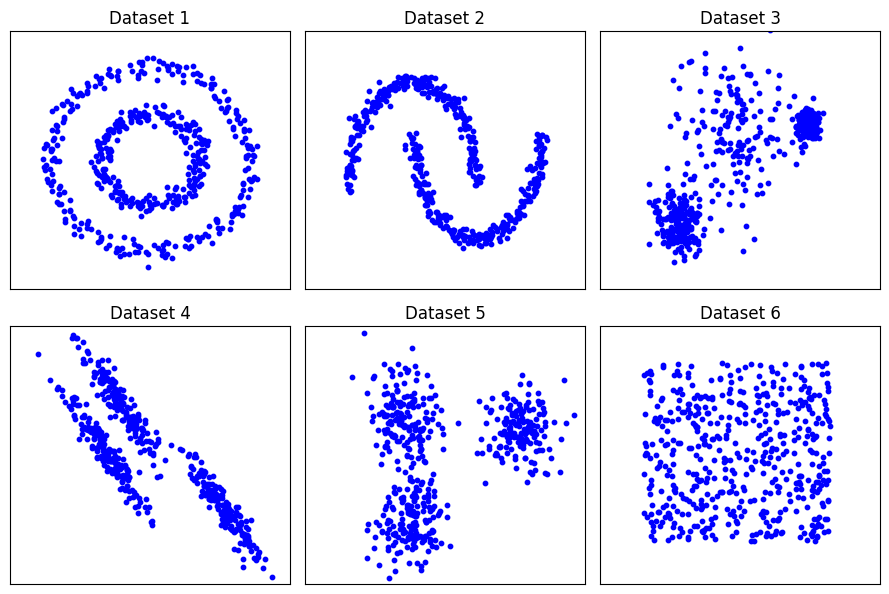

In [215]:
# Datasets creation
n_samples = 500
seed = 30

noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

rng = np.random.RandomState(seed)

no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

data = [
    noisy_circles,  
    noisy_moons,    
    varied,         
    aniso,          
    blobs,         
    no_structure,  
]

labels = [
    "noisy_circles",
    "noisy_moons",
    "varied_blobs",
    "aniso_blobs",
    "blobs",
    "no_structure"
]

labeled_data = [(X, y, label) for (X, y), label in zip(data, labels)]

# Plot
plt.figure(figsize=(9, 9))
for i, (X, y) in enumerate(data):
    X = StandardScaler().fit_transform(X)
    plt.subplot(3, 3, i + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, color="b")
    plt.title(f"Dataset {i+1}")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()
plt.show()


In [216]:
colors = ['blue', 'orange', 'green', 'red']

def calculate_and_plot_2d_clusters(X, k, ax, title, p):
    X = StandardScaler().fit_transform(X)
    n_samples = X.shape[0]
    dist_matrix = getDistMatrix(n_samples, X, p)

    # alg_maiores_distancias
    r_maiores, centers_maiores = alg_maiores_distancias(n_samples, k, dist_matrix)
    labels_maiores = np.zeros(n_samples, dtype=int)
    for p in range(n_samples):
        distances_to_centers = [dist_matrix[p][center] for center in centers_maiores]
        labels_maiores[p] = np.argmin(distances_to_centers)

    # alg_busca_binaria
    r_busca, centers_busca = alg_busca_binaria(n_samples, k, dist_matrix)
    labels_busca = np.zeros(n_samples, dtype=int)
    for p in range(n_samples):
        distances_to_centers = [dist_matrix[p][center] for center in centers_busca]
        labels_busca[p] = np.argmin(distances_to_centers)

    # Plot    
    ax[0].scatter(X[:, 0], X[:, 1], c=[colors[label % len(colors)] for label in labels_maiores], s=10)
    ax[0].set_title(f"{title} - alg_1")
    ax[0].set_xlim(-2.5, 2.5)
    ax[0].set_ylim(-2.5, 2.5)
    ax[0].set_xticks(())
    ax[0].set_yticks(())

    ax[1].scatter(X[:, 0], X[:, 1], c=[colors[label % len(colors)] for label in labels_busca], s=10)
    ax[1].set_title(f"{title} - alg_2")
    ax[1].set_xlim(-2.5, 2.5)
    ax[1].set_ylim(-2.5, 2.5)
    ax[1].set_xticks(())
    ax[1].set_yticks(())

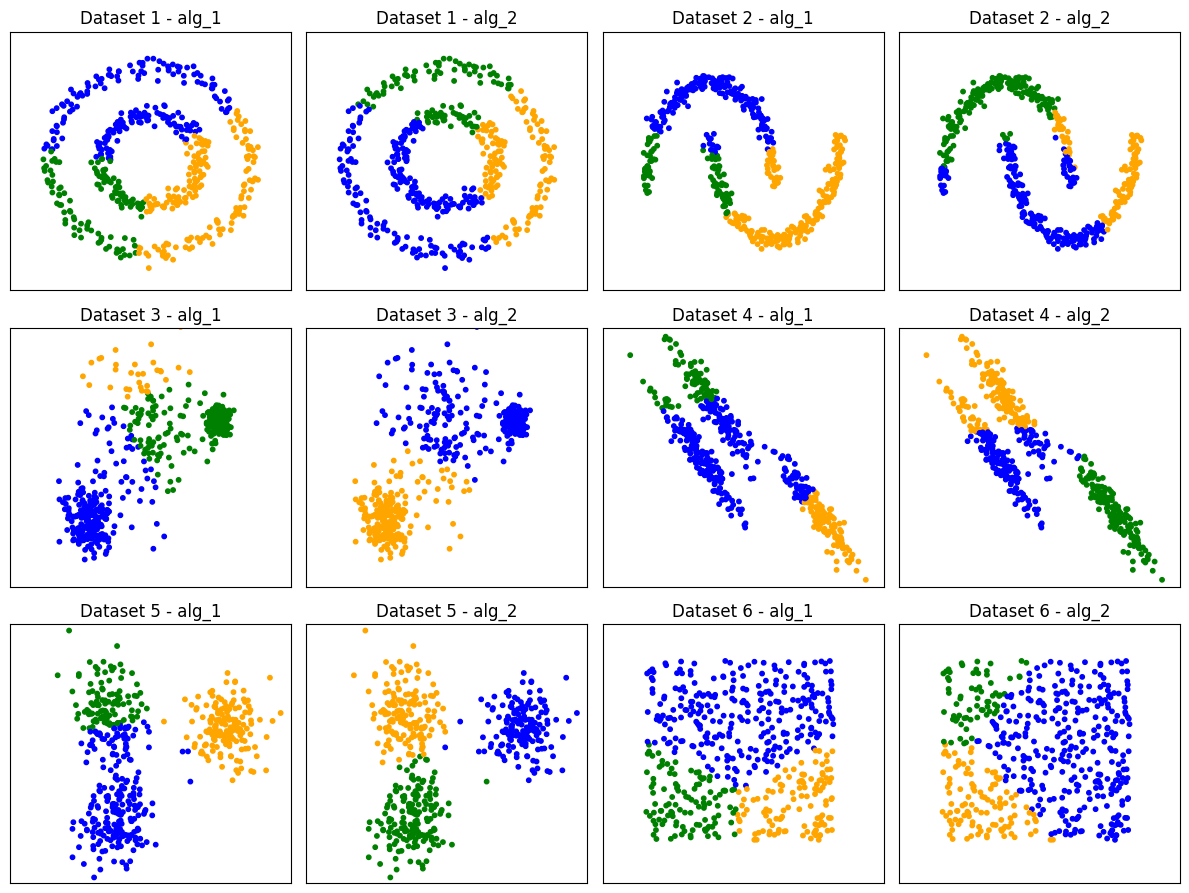

In [217]:
plt.figure(figsize=(12, 12))

k=3
for i, (X, y) in enumerate(data):
    if X is not None:
        ax = plt.subplot(4, 4, 2 * i + 1)
        calculate_and_plot_2d_clusters(X, k, [ax, plt.subplot(4, 4, 2 * i + 2)], f"Dataset {i+1}", p=2)

plt.tight_layout()
plt.show()

### Distribuição normal multivariada

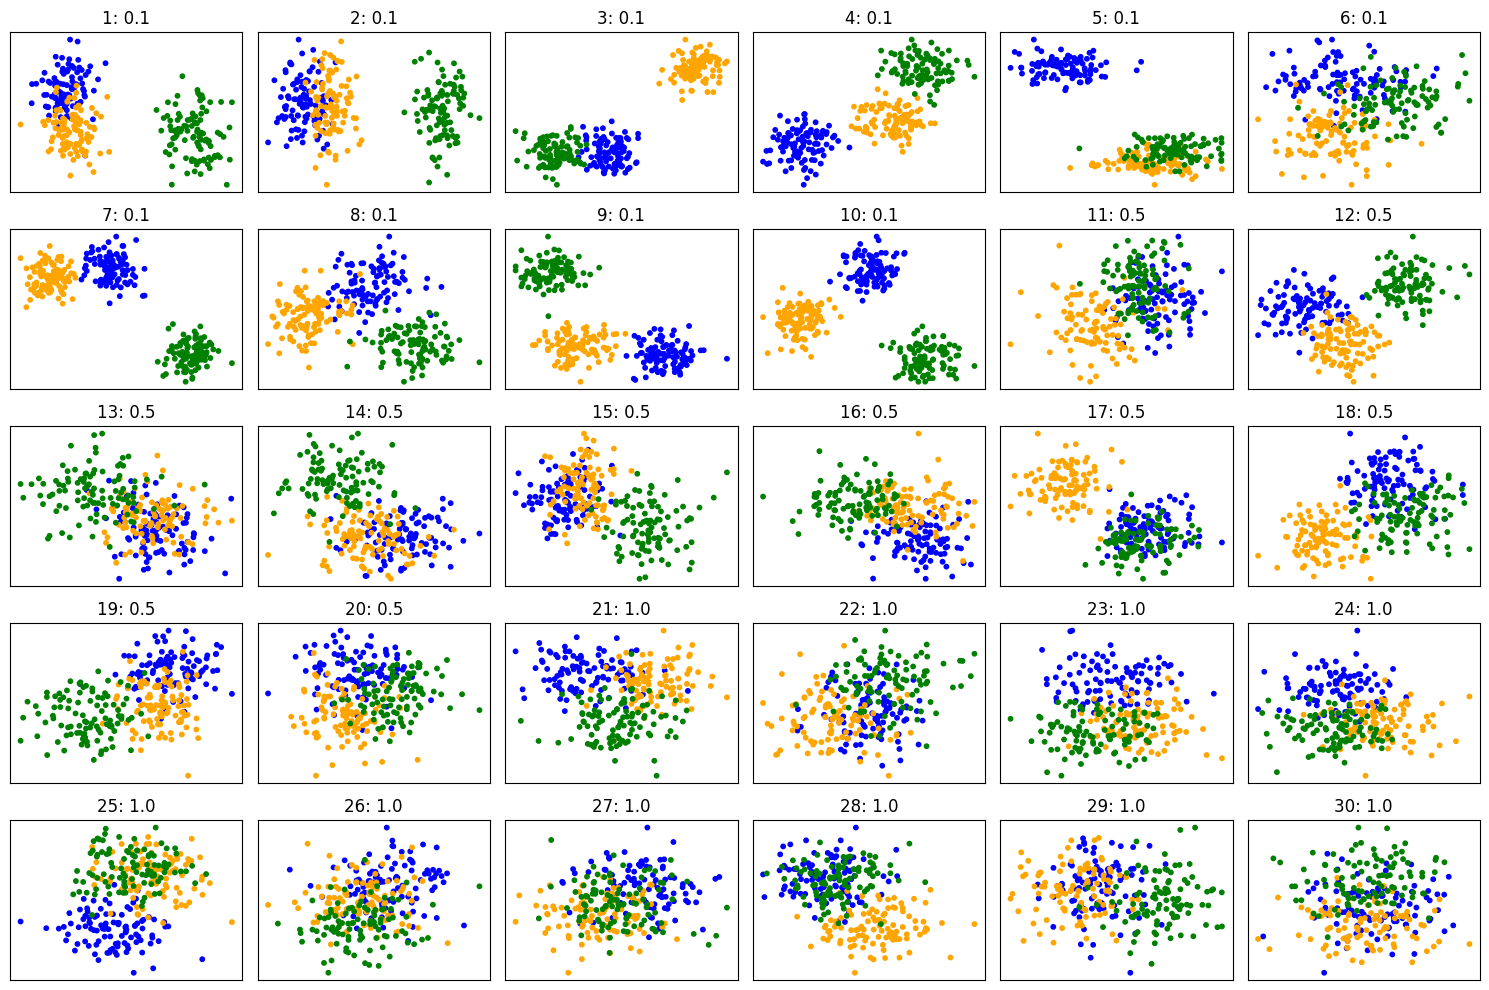

In [218]:
def generate_datasets(dts=10, cts=3, points_center=100, desv=None):
    if desv is None:
        desv = [0.1, 0.5, 1.0]  # desvios: baixo, médio e alto
    datasets = []

    ind = 1
    for desvio in desv:
        for _ in range(dts):
            centers = np.random.rand(cts, 2) * 4 - 2
            X = []
            y = []
            for i, center in enumerate(centers):
                points = np.random.multivariate_normal(center, np.eye(2) * desvio, points_center)
                X.append(points)
                y.append(np.full(points_center, i))
            X = np.vstack(X)
            y = np.hstack(y)
            datasets.append((X, y, f"{ind}: {desvio}"))
            ind += 1
            
    return datasets

# gerando os conjuntos de dados
data_2 = generate_datasets()

# Plots
def plot_generated_datasets(datasets):
    plt.figure(figsize=(15, 10))
    for i, (X, y, title) in enumerate(datasets):
        ax = plt.subplot(5, 6, i + 1)
        cluster_colors = [colors[label % len(colors)] for label in y]
        ax.scatter(X[:, 0], X[:, 1], c=cluster_colors, s=10)
        ax.set_title(title)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.show()

plot_generated_datasets(data_2)

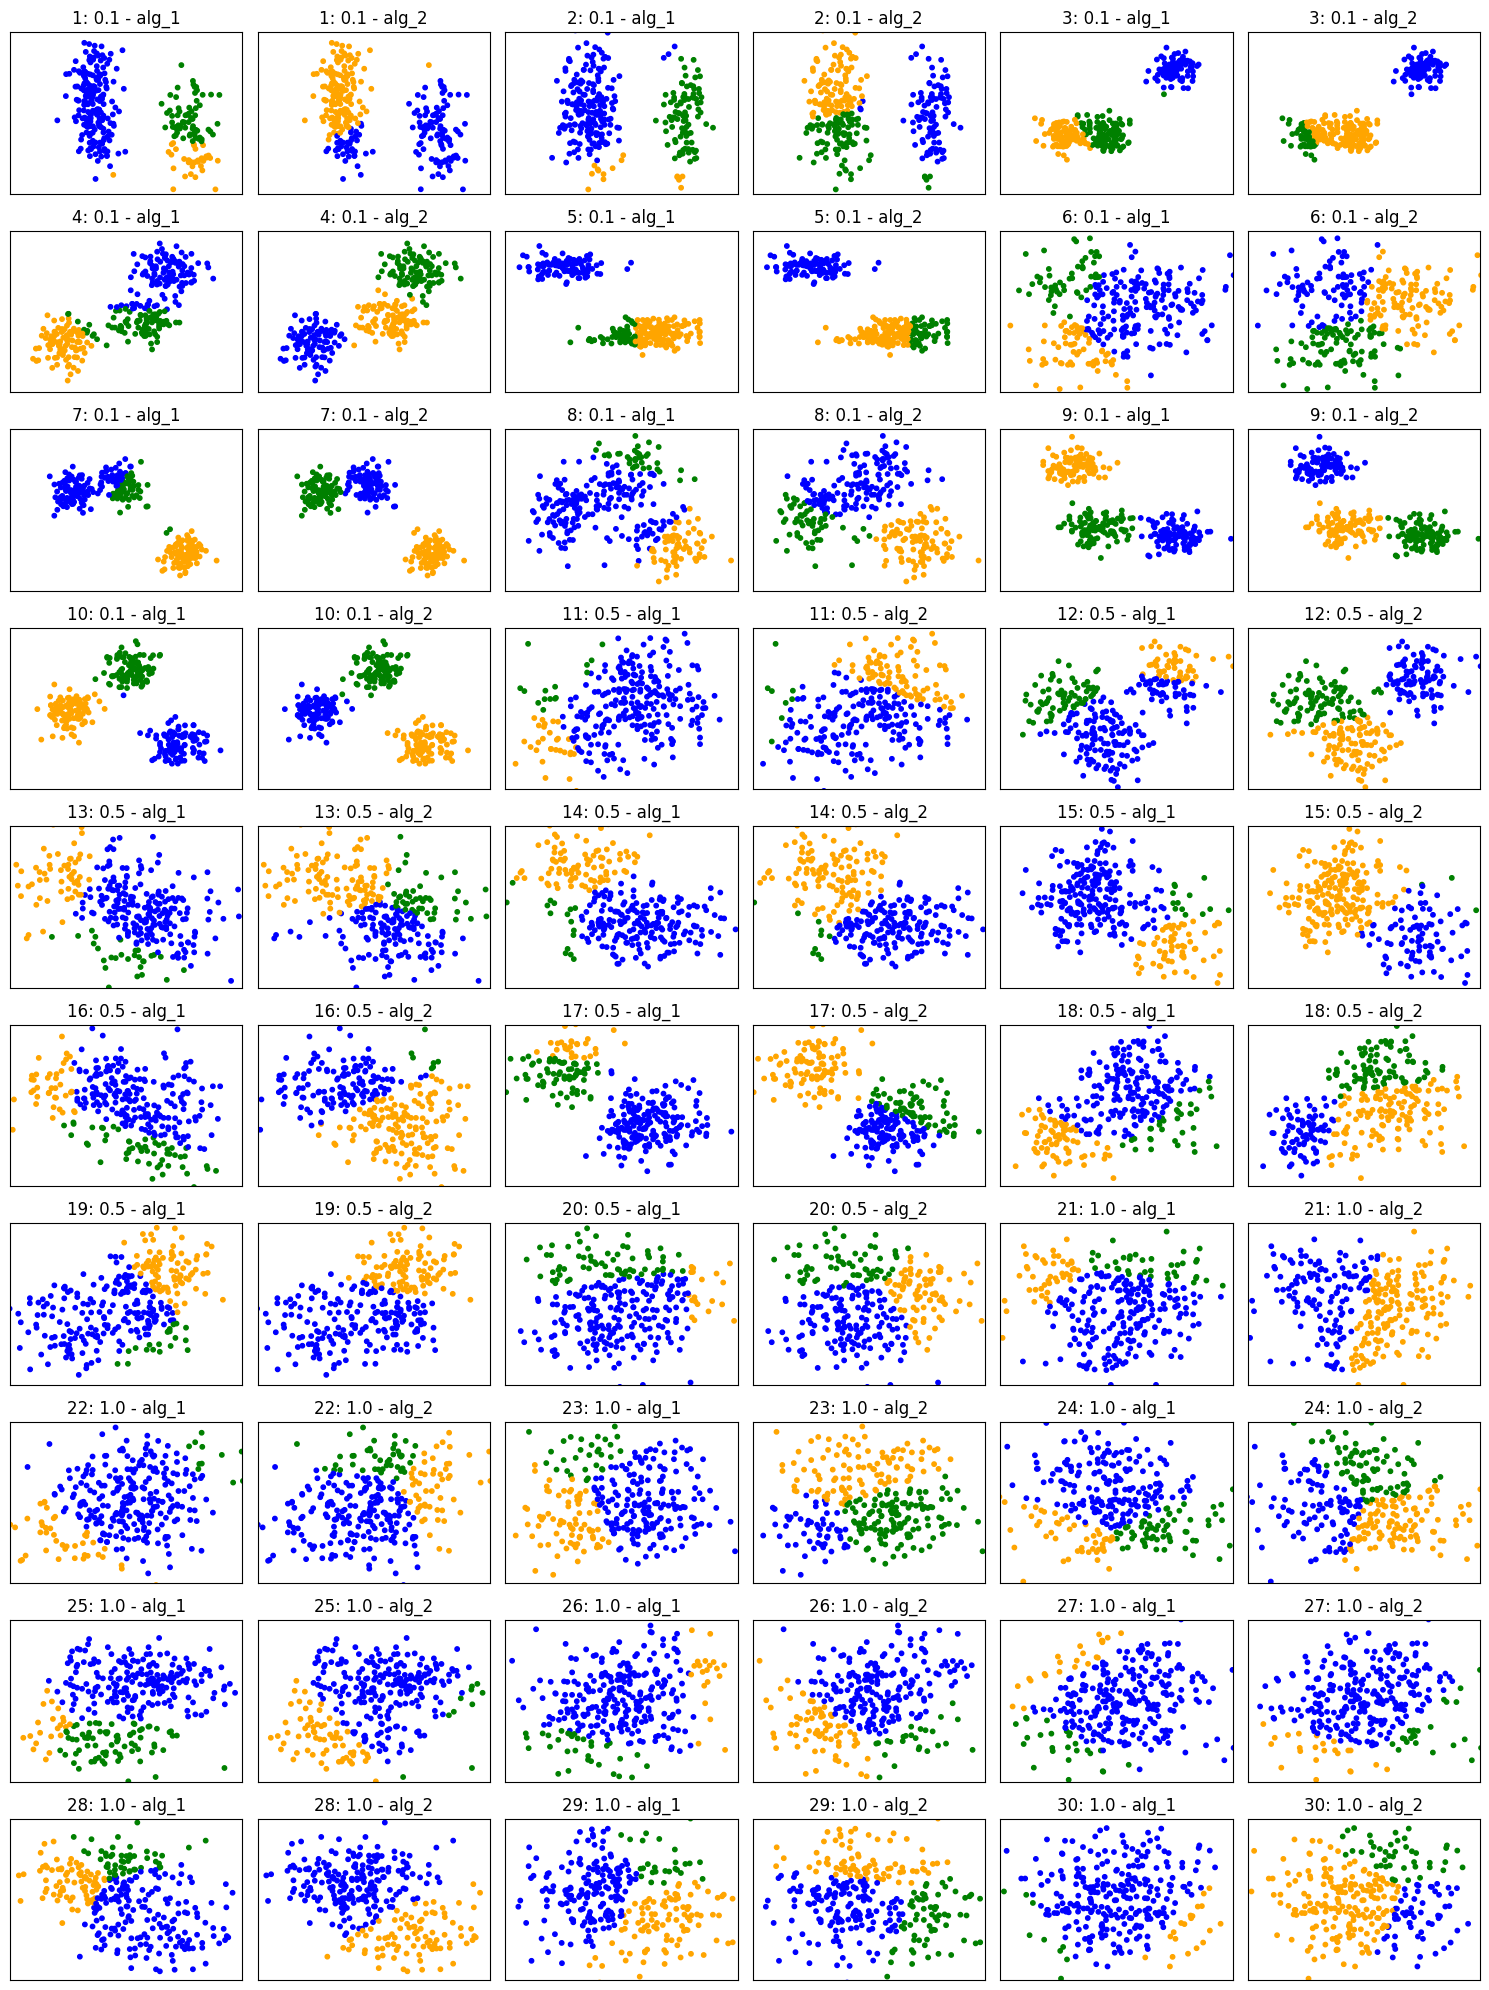

In [219]:
n_datasets = len(data_2)
n_rows = (n_datasets * 2 + 1) // 6
plt.figure(figsize=(15, n_rows*2))

for i, (X, y, title) in enumerate(data_2):
    ax = plt.subplot(n_rows, 6, 2 * i + 1)
    calculate_and_plot_2d_clusters(X, k=3, ax=[ax, plt.subplot(n_rows, 6, 2 * i + 2)], title=title, p=2)

plt.tight_layout()
plt.show()

## Experimentos

In [220]:
# definindo o score de silhueta quando a métrica não é euclidiana
def silhouette_score_custom(X, labels, distance_matrix):
    unique_labels = np.unique(labels)
    n_samples = len(labels)
    if len(unique_labels) == 1:
        return 0.0
    
    a = np.zeros(n_samples)
    for label in unique_labels:
        mask = (labels == label)
        cluster_points = distance_matrix[np.ix_(mask, mask)]
        a[mask] = np.mean(cluster_points, axis=1)
    
    b = np.full(n_samples, np.inf)
    for label in unique_labels:
        mask = (labels == label)
        other_labels = unique_labels[unique_labels != label]
        for other_label in other_labels:
            other_mask = (labels == other_label)
            other_cluster_points = distance_matrix[np.ix_(mask, other_mask)]
            mean_dist = np.mean(other_cluster_points, axis=1)
            b[mask] = np.minimum(b[mask], mean_dist)
    
    silhouette_scores = (b - a) / np.maximum(a, b)
    return np.mean(silhouette_scores)

# calcular métricas de qualidade
def evaluate(X, y_true, labels, metric="euclidean", matrix=None):
    if(metric == "euclidean"):
        silhouette = silhouette_score(X, labels, metric=metric)
    else:
        silhouette = silhouette_score_custom(X, labels, matrix)
    rand_index = adjusted_rand_score(y_true, labels)
    return silhouette, rand_index

# realizar experimentos com o algoritmo de maiores distâncias
def run_maiores_distancias(datasets, k=3, exec=30):
    results = []
    
    for X, y_true, label in datasets:
        X = StandardScaler().fit_transform(X)
        N = len(X)
        
        for p in [1, 2]:
            dist_matrix = getDistMatrix(N, X, p)
            distance_type = "manhattan" if p == 1 else "euclidean"
            
            for _ in range(exec):
                start_time = time.time()
                r, centers = alg_maiores_distancias(N, k, dist_matrix)
                exec_time = time.time() - start_time
                
                labels = np.argmin(dist_matrix[:, centers], axis=1)
                
                silhouette, rand_index = evaluate(X, y_true, labels, distance_type, dist_matrix)
                
                results.append([label, distance_type, r, 'Maiores Distancias', silhouette, rand_index, exec_time])
    
    return np.array(results)

# salvar tabelas
def save_csv(results, filename="clustering_results.csv"):
    header = ["Dataset", "Distance", "Radius", "Algorithm", "Silhouette Score", "Adjusted Rand Index", "Execution Time"]

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(results)


In [221]:
# encontrar raio k-means scikit
def get_radius(N, centers, labels, dist_matrix):
    max_radii = []
    
    for i in range(len(centers)):
        cluster_indices = np.where(labels == i)[0]
        max_distance = -np.inf
        for idx in cluster_indices:
            for center_idx in range(len(centers)):
                if labels[idx] == i:
                    max_distance = max(max_distance, dist_matrix[idx][center_idx])
        max_radii.append(max_distance)
    
    return max(max_radii)

# realizar experimentos com o algoritmo da scikit
def run_kmeans(datasets, k=3, num_executions=30):
    results = []

    for X, y_true, label in datasets:
        X = StandardScaler().fit_transform(X)
        N = len(X)

        for p in [1, 2]:
            dist_matrix = getDistMatrix(N, X, p)
            distance_type = "manhattan" if p == 1 else "euclidean"
            
            for _ in range(num_executions):
                start_time = time.time()
                
                kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
                labels = kmeans.labels_
                exec_time = time.time() - start_time
                centers = kmeans.cluster_centers_
                radius = get_radius(N, centers, labels, dist_matrix)

                
                silhouette, rand_index = evaluate(X, y_true, labels, distance_type, dist_matrix)

                results.append([label, distance_type, radius, 'KMeans', silhouette, rand_index, exec_time])
    
    return np.array(results)

In [222]:
# tempo de execução médio 1,5 min

results_data = run_maiores_distancias(labeled_data)
print("Dataset 1: experimentos com algoritmo 1 concluídos")
results_kmeans_1 = run_kmeans(labeled_data)
print("Dataset 1: experimentos com k-means concluídos")
results_data_2 = run_maiores_distancias(data_2)
print("Dataset 2: experimentos com algoritmo 1 concluídos")
results_kmeans_2 = run_kmeans(data_2)
print("Dataset 1: experimentos com k-means concluídos")

Dataset 1: experimentos com algoritmo 1 concluídos
Dataset 1: experimentos com k-means concluídos
Dataset 2: experimentos com algoritmo 1 concluídos
Dataset 1: experimentos com k-means concluídos


In [223]:
def aggregate_experiment_results(array1, array2, csv=None):
    combined_array = np.concatenate([array1, array2])

    df = pd.DataFrame(combined_array, columns=['label', 'distance_type', 'radius', 'algorithm', 'silhouette', 'rand_index', 'exec_time'])

    df[['silhouette', 'rand_index', 'exec_time']] = df[['silhouette', 'rand_index', 'exec_time']].astype(float)

    summary_df = df.groupby(['label', 'distance_type', 'algorithm']).agg(
        silhouette_mean=('silhouette', 'mean'),
        silhouette_std=('silhouette', 'std'),
        rand_index_mean=('rand_index', 'mean'),
        rand_index_std=('rand_index', 'std'),
        exec_time_mean=('exec_time', 'mean'),
        exec_time_std=('exec_time', 'std')
    ).reset_index()
    
    if csv:
        summary_df.to_csv(csv, index=True)
        
    return summary_df

summary_table_1 = aggregate_experiment_results(results_data, results_kmeans_1, csv='resultado_1.csv')
summary_2 = aggregate_experiment_results(results_data_2, results_kmeans_2)
summary_2['label'] = summary_2['label'].astype(str)
summary_2['label_first_number'] = summary_2['label'].str.extract(r'(\d+)').astype(int)
summary_table_2 = summary_2.sort_values(by='label_first_number').drop(columns=['label_first_number'])
summary_table_2.to_csv('resultado_2.csv', index=False)